# Convolutional Neural Network as Cellular Automata

Based on: https://doi.org/10.1103/PhysRevE.100.032402

Quoting Wikipedia:

> A cellular automaton consists of a regular grid of cells, each in one of a finite number of states, such as on and off [...]. The grid can be in any finite number of dimensions. For each cell, a set of cells called its neighbourhood is defined relative to the specified cell. An initial state (time t = 0) is selected by assigning a state for each cell. A new generation is created (advancing t by 1), according to some fixed rule (generally, a mathematical function) that determines the new state of each cell in terms of the current state of the cell and the states of the cells in its neighbourhood. Typically, the rule for updating the state of cells is the same for each cell and does not change over time, and is applied to the whole grid simultaneously [...]
>
> <cite>https://en.wikipedia.org/wiki/Cellular_automaton</cite>

The important thing here is that cellular automatons are local, i.e. the next state of each cell depends only on the cells in its neighbourhood. This principle of locality is also a basis for applying convolutional filters, which combine information from a single part of the image at a time. Expanding on this similarity, we can ponder whether cellular automatons and convolutional neural networks have more things in common. Let's check this out!

## CAs and convolutions in plain Python

We'll define a few simple CAs to learn the techniques we'll be using further. The CAs will:
* be defined on a square grid
* have 2 states - so called binary CA, the states are usually called dead (0) and alive (1)
* use Moore neighbourhood - a square of 3 by 3 cells with a cell of reference in the centre

### Utils

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
from itertools import count

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (7, 7)

def plot_state(state):
    clear_output(wait=True)
    plt.imshow(state)
    plt.axis(False)
    plt.show()

def run_ca(ca, size=(100, 100), p_alive=0.5, iters=None):
    iters = range(iters) if iters else count()
    
    state = np.random.choice([0, 1], size=size, p=[1-p_alive, p_alive])
    m, n = state.shape
    state[m//2, n//2] = 1 if p_alive > 0 else 0 # ensure at least 1 living cell
    plot_state(state)
    for _ in iters:
        time.sleep(0.1)
        state = ca(state)
        plot_state(state) 

### Task 1: Rule-based CA
The simplest automaton can be defined by pattern-matching rules for each possible input. No big deal, we just need to pay attention to boundary conditions.

In [2]:
def k(a):
    """
    Convert array to a tuple for use as a dictionary key.
    """
    return tuple(np.array(a).ravel())

def triangles(state):
    survives = set(k(s) for s in (
        [[0, 0, 1], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, 1]],
        [[0, 0, 0], [1, 0, 0], [0, 0, 0]],
    ))
    
    new_state = np.zeros_like(state)
    
    # TODO: We want to have a state grid that's _wrapped_ around,
    # left to right and top to bottom, so that CA rules
    # can be safely applied at the boundary.
    # Hint: use np.pad with the right mode.
    state_pad = np.pad(state, 1, 'wrap')
    
    for i in range(state.shape[0]):
        for j in range(state.shape[1]):
            if k(state_pad[i:i+3, j:j+3]) in survives:
                new_state[i][j] = 1
    
    return new_state

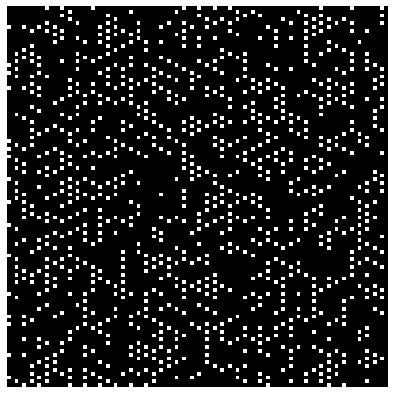

In [ ]:
run_ca(triangles, p_alive=0.0003)

### Task 2: Convolution
Let's build a simple convolution which sums the numbers in a 3 by 3 square just to see how it works.

In [ ]:
from scipy.signal import convolve2d

def conv_sum_neighbours(a):
    # TODO: Define a convolution kernel that will sum all values
    # inside a 3x3 block apart from the center square.
    # Hint: the kernel will be a 3x3 array with 1s and 0s in the right places.
    kernel = np.pad([[0]], 1, constant_values=1)
    return convolve2d(a, kernel, mode='valid')

# test inputs have size 3x3 just to make things simple
def conv_test():
    x = np.arange(1, 10).reshape(3, 3)
    print(x)
    print(x.sum(), conv_sum_neighbours(x))
    
    eq = []
    for i in range(10):
        x = np.random.rand(3, 3)
        eq.append(np.isclose(conv_sum_neighbours(x), x.sum() - x[1, 1]))
    print(all(eq))

conv_test()

## Totalistic CA

Totalistic CAs don't care about layout of cells in a neighbourhood, they just compute some neighbourhood statistic like a number of living cells. As we already know, the sum of values in the neighbouring cells is a perfect use case for a convolution!

The convolution will be computed for all cells at once using arcane knowledge of the fast Fourier transform. This also has a nice side effect that we get wrapped boundaries for free. It's not that important how this FFT works, you can treat it as a black box. The important bit is that we use a convolution to implement a CA transition function.

### Utils

In [ ]:
# adapted from: https://github.com/thearn/game-of-life
from numpy.fft import fft2, ifft2

def fft_convolve2d(x, y):
    """
    2D convolution, using FFT
    """
    fr = fft2(x)
    fr2 = fft2(np.flipud(np.fliplr(y)))
    m, n = fr.shape
    cc = np.real(ifft2(fr*fr2))
    cc = np.roll(cc, - int(m / 2) + 1, axis=0)
    cc = np.roll(cc, - int(n / 2) + 1, axis=1)
    return cc.round()

### Task 3: Conway's game of Life
The most famous cellular automaton that exhibits complex behaviour

In [ ]:
def conway(state):
    kernel = np.zeros_like(state)
    m, n = kernel.shape
    
    # TODO: define a 3x3 convolution kernel that will count living neighbours (state := 1) of the cell
    kernel[m//2-1 : m//2+2, n//2-1 : n//2+2] = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])

    # 2d table with counts of living neighbours for each corresponding cell from the state
    neighbours_alive = fft_convolve2d(state, kernel)
    
    new_state = np.zeros_like(neighbours_alive)
    
    born = [3]
    survives = [2, 3]
    # TODO: place born & survives arrays in the right places
    # states: 0 - dead, 1 - alive
    new_state[np.where((state == 0) & np.isin(neighbours_alive, born))] = 1
    new_state[np.where((state == 1) & np.isin(neighbours_alive, survives))] = 1

    return new_state   

In [ ]:
run_ca(conway)

## Day and night automaton
We've seen the `triangles` CA which behaves orderly up to a point, but then quite reliably transforms into a random mess and also the `conway` CA that can have runs of varying length and complexity. What determines the CA complexity? Let's compare a few other automatons with rules that differ only slightly.

### Utils

In [ ]:
def n_sum_ca(born, survives):
    def ca(state):
        kernel = np.zeros_like(state)
        m, n = kernel.shape
        kernel[m//2-1 : m//2+2, n//2-1 : n//2+2] = np.pad([[0]], 1, constant_values=1)

        neighbours_alive = fft_convolve2d(state, kernel)

        new_state = np.zeros_like(neighbours_alive)
        new_state[np.where((state == 0) & np.isin(neighbours_alive, born))] = 1
        new_state[np.where((state == 1) & np.isin(neighbours_alive, survives))] = 1

        return new_state
    return ca

### Task 4: CA comparison
Run each of the following CAs and just observe the results. The first CA is called "day and night", becuase it exhibits symmetry between dead and alive states.

In [ ]:
day_and_night = [
    (f'day_and_night_{i}', n_sum_ca(born, survives))
    for i, (born, survives)
    in enumerate([
        ([3, 6, 7, 8], [3, 4, 6, 7, 8]),
        ([3, 4, 6, 7, 8], [3, 4, 6, 7, 8]),
        ([3, 6, 7, 8], [3, 6, 7, 8]),
        ([3, 4, 6, 7, 8], [3, 6, 7, 8])
    ])
]

def run(i, **kwargs):
    name, ca = day_and_night[i]
    run_ca(ca, **kwargs)
    print(name, kwargs)

In [ ]:
run(0, iters=100, p_alive=0.5)

In [ ]:
run(1, iters=100, p_alive=0.125)

In [ ]:
run(2, iters=100, p_alive=0.875)

In [ ]:
run(3, iters=30, p_alive=0.5)

In [ ]:
run(3, iters=100, p_alive=0.78)

In [ ]:
run(3, iters=100, p_alive=0.22)

As we can see, modifying the rules slightly can change the automaton behaviour a lot. In case of our automata, we could probably start building intuition about the outcomes, but the symmetry we encountered is just the matter of this specific "day and night" automaton. To make matters worse, the last example shows that the behaviour can vary based on the input distribution... and we're only looking at totalistic automata. Things get even more unpredictable for rule-based CAs.

How to quantify this? How to quantify the complexity?

## Wolfram classification & entropy
Approaching the problem differently, we could try to describe automatons qualitatively, by pointing out the kinds of outcomes they produce. The most prominent classification was proposed by Wolfram:

### Wolfram classification
* Class 1: Nearly all initial patterns evolve quickly into a stable, homogeneous state. Any randomness in the initial pattern disappears.
* Class 2: Nearly all initial patterns evolve quickly into stable or oscillating structures. Some of the randomness in the initial pattern may filter out, but some remains. Local changes to the initial pattern tend to remain local.
* Class 3: Nearly all initial patterns evolve in a pseudo-random or chaotic manner. Any stable structures that appear are quickly destroyed by the surrounding noise. Local changes to the initial pattern tend to spread indefinitely.
* Class 4: Nearly all initial patterns evolve into structures that interact in complex and interesting ways, with the formation of local structures that are able to survive for long periods of time.

The descriptions are from: https://en.wikipedia.org/wiki/Cellular_automaton#Classification

### Entropy
To quantify the automaton complexity, we can look at all possible automaton input neighbourhoods, apply the CA transformation to each one of them, each time producing as output a new state for a single cell. $\lambda$ is defined as the ratio of such output cells that are alive. $\lambda = 0$ when all outputs are dead, $\lambda = 1$ when all are alive, and $\lambda = 0.5$ when the two outcomes are balanced. A rule of thumb is that the closer $\lambda$ is to 0.5, the greater the automaton complexity and the higher Wolfram's class.

We won't use $\lambda$ directly, however we'll use a metric that's correlated with it: the automaton entropy. Let's assume we apply a CA transition once to an input that has a uniform distribution of all possible neighbourhoods. After the one CA transition, for each possible neighbourhood $\sigma$ we calculate its probability of appearing in the output $p_\sigma$ and calculate the entropy of their distribution. The number we get is called automaton entropy:

$$H_{ca} = -\sum_{\sigma} p_\sigma \log_2{p_\sigma}$$

For binary automata (2 states) with Moore neighborhood (9 cells), the entropy ranges from 0 (all inputs map to the same output neighbourhood) to 9 (uniform neighbourhood distribution in output). Let's find the value of entropy for the automata we already know. Since synthesising an image with a uniform input distribution is complicated, we'll approximate it by applying the CA to all possible input neighbourhoods wrapped around one by one and then adding up the counts of output neighbourhoods.

### Task 5: Calculating automaton entropy

In [ ]:
from itertools import product
from scipy.stats import entropy
from collections import Counter

def all_combinations(m, d):
    '''
    Make an array of all d dimensional inputs
    consisting of m possible values
    '''
    
    sq = int(np.sqrt(d))
    
    indices = np.tile(np.array([np.arange(m)]).T, d)

    all_combos = list(product(*list(indices.T)))
    out = np.reshape(np.array(all_combos), (-1, sq, sq))
    
    return out

def simple_ca_entropy(ca):
    # TODO: Provide the right parameters for the functions.
    outputs = Counter(k(ca(c)) for c in all_combinations(2, 9))
    return entropy(list(outputs.values()), base=2)

In [ ]:
print('triangles', simple_ca_entropy(triangles))
print('conway', simple_ca_entropy(conway))
for name, ca in day_and_night:
    print(name, simple_ca_entropy(ca))

## CNN as CA

Convolutional Neural Networks demonstrated great success in the modelling of complex systems, like speech patterns
and physics simulations. We can try to use them in the prediction of the output of a CA after one step.

### Network model

We will use one of the network architectures proposed by the authors of the paper:
![CNN architecture](cnn_architecture.png "CNN architecture")

We will use PyTorch in these examples as it allows us to trace operations on the lower level.

In [ ]:
import torch

from tqdm import tqdm
from .pytorch.train_ca import initialize_model
from .pytorch.ca_funcs import make_table_walk, make_ca

seed = 0
print('seed =', seed)

np.random.seed(seed)
torch.random.manual_seed(seed)

First, we define various hyper-parameters of the network:

In [ ]:
num_classes = 2
samples = 500
input_dims = [10, 10]
layer_dims = [100] + [100] * 11
batch_size = 10
num_batches = samples / batch_size
learning_rate = 1e-4
training_epochs = 1500
display_step = int(training_epochs / 10)
loss = torch.nn.MSELoss()

Then, we can build the model:

In [ ]:
model = initialize_model(input_dims, layer_dims)
if torch.cuda.is_available():
    model.cuda()
print(model)

### Basic training

We start by defining utility methods for data generation.

In [ ]:
M = 2
D = 3 * 3
ALL_INPUTS = all_combinations(M, D)

def generate_CA_train_data(ca, height=10, width=10, n_samples=500):
    X_train = torch.from_numpy(np.random.choice([0, 1], (n_samples, height, width), p=[.5, .5])).float()
    Y_train = ca(X_train).float()
    return X_train, Y_train

def sample_CAs(seed=None):
    if seed:
        np.random.seed(seed)

    inputs = ALL_INPUTS
    outputs = make_table_walk(len(ALL_INPUTS))
    for o in outputs:
        yield make_ca(inputs, o)

Then, we can define the training loop:

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def learn_CA(ca, model, optimizer):
    losses = []

    for _ in tqdm(range(training_epochs)):
        X_train, Y_train = generate_CA_train_data(ca, *input_dims, n_samples=samples)

        if torch.cuda.is_available():
            X_train = X_train.cuda()
            Y_train = Y_train.cuda()

        optimizer.zero_grad()
        Y_pred = model(X_train)
        l = loss(Y_train, Y_pred)
        l.backward()
        optimizer.step()
        losses.append(l.item())
    return losses

## Experiments

We can train the network and plot the loss function values.

In [ ]:
ca = list(sample_CAs(seed=0))[250]
losses = learn_CA(ca, model, optimizer)

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.loglog()

Then we can check the output of the model:

In [ ]:
from .pytorch.ca_funcs import make_glider

def display_sample_output(model):
    x = make_glider(10)
    X_test = torch.from_numpy(x.reshape(1, 10, 10)).float()
    Y_test = ca(X_test).float()

    if torch.cuda.is_available():
        X_test = X_test.cuda()
    Y_pred = model(X_test)


    if torch.cuda.is_available():
        X_test = X_test.cpu()
        Y_pred = Y_pred.cpu()

    X_test = X_test.detach().numpy()
    Y_test = Y_test.detach().numpy()
    Y_pred = Y_pred.detach().numpy()

    plt.figure(figsize=(12, 4))

    plt.subplot(141)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(142)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Expected Output")

    plt.subplot(143)
    plt.imshow(Y_pred[0])
    plt.axis('off')
    plt.title("Observed Output")

    plt.subplot(144)
    plt.imshow((Y_pred[0] - Y_test[0]) ** 2)
    plt.axis('off')

display_sample_output(model)

### Task 6: Experiment
